In [1]:
# Add the current directory to the load path to find the module
using Pkg
Pkg.activate(@__DIR__)
include("src/HubbardModel.jl")
using .HubbardModel

  Activating project at `c:\Users\noahs\work\hubbard`


# band structure and dos computation and plotting

Calculating Fermi level on 50 x 50 grid...
  Calculating eigenvalues for Fermi level...
  Calculated Fermi level E_F = -0.45361960120809663 for nup=[0.8, 0.8], ndown=[0, 0]
Calculating Fermi level on 50 x 50 grid...
  Calculating eigenvalues for Fermi level...
  Calculated Fermi level E_F = -0.17334913006091457 for nup=[0.62, 0.18], ndown=[0.18, 0.62]
Calculating band structure...
Band structure calculation complete. Energies shifted by E_F = -0.45361960120809663.
Calculating band structure...
Band structure calculation complete. Energies shifted by E_F = -0.17334913006091457.

Calculating DOS on 500 x 500 grid...
Calculating eigenvalues...
Shifting DOS energies by E_F = -0.45361960120809663...
Calculating broadened DOS (σ = 0.05) with shifted energies...
DOS calculation complete.

Calculating DOS on 500 x 500 grid...
Calculating eigenvalues...
Shifting DOS energies by E_F = -0.17334913006091457...
Calculating broadened DOS (σ = 0.05) with shifted energies...
DOS calculation complete.


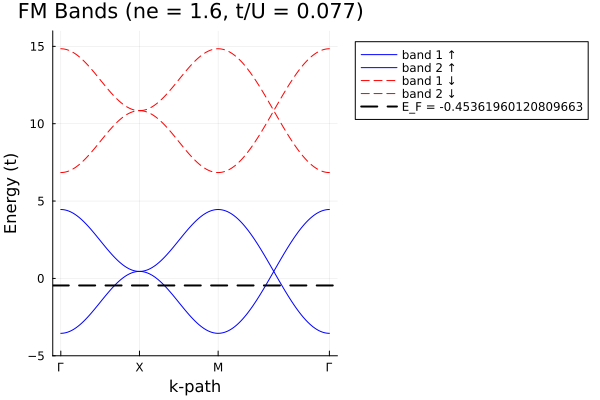

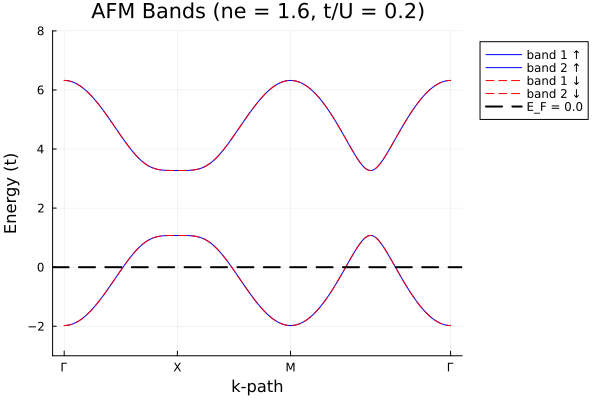

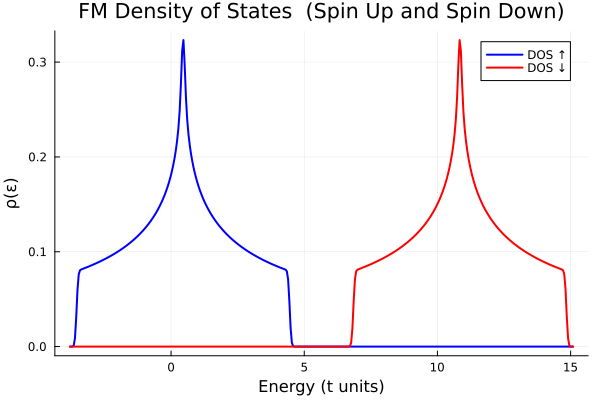

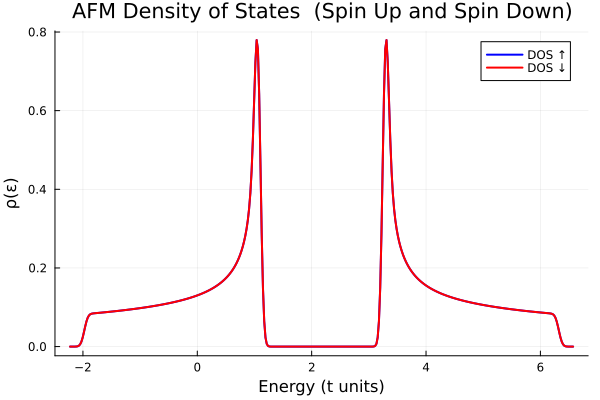

In [2]:
# --- Parameters --- 
t = 1.0                # we set our unit of energy to t. everything we compute will be in terms of t.
ne = 2.0
Ufm_val = t / 0.077 
Uafm_val = t / 0.2
Nk_scf = 50             # number of k-points for the mean field procedure
Nk_bands = 100        # number of k-points for the band structure
Nk_dos_grid = 500       # number of k-points per dim for DOS grid
beta = 300             # inverse temperature
scf_tol = 1e-6
scf_maxiter = 200
dos_sigma = 0.05        # smearing width for DOS.
dos_points = 400

# --- Setup MFParams --- 
p_fm  = MFParams(U=Ufm_val,  t=t, ne=ne, Nk=Nk_scf, β=beta, tol=scf_tol, maxiter=scf_maxiter)
p_afm = MFParams(U=Uafm_val, t=t, ne=ne, Nk=Nk_scf, β=beta, tol=scf_tol, maxiter=scf_maxiter)

# --- Calculate Band Structure for ferromagnetic and antiferromagnetic states 
# we use the values from the paper; see the readme
nup_fm = fill(0.8, 2)
ndown_fm = fill(0, 2)
nup_afm = [0.62, 0.18]
ndown_afm = [0.18, 0.62]

# Generate k-path for FM (uses original BZ path KPATH)
k_path_fm, k_dist_fm, tick_pos_fm, tick_labels_fm = generate_k_path(; points=[], num_points_per_segment=Nk_dos_grid, supercell=false) 
# Generate k-path for AFM (uses magnetic BZ path KPATH_AFM)
k_path_afm, k_dist_afm, tick_pos_afm, tick_labels_afm = generate_k_path(; points=[], num_points_per_segment=Nk_dos_grid, supercell=false) 

# Calculate Fermi levels (optional, set E_F=0.0 if not needed for plotting)
Efm_f = calculate_fermi_level(p_fm, nup_fm, ndown_fm)
Eafm_f = calculate_fermi_level(p_afm, nup_afm, ndown_afm)

# Calculate bands along respective paths
em_fm_up, em_fm_dn = calculate_bands(p_fm, nup_fm, ndown_fm, k_path_fm, E_F=Efm_f)
em_afm_up, em_afm_dn = calculate_bands(p_afm, nup_afm, ndown_afm, k_path_afm, E_F=Eafm_f)

# --- Plot Band Structure --- 
# Plot FM bands along KPATH
plot_bands(k_dist_fm, em_fm_up, em_fm_dn, "FM Bands (ne = 1.6, t/U = 0.077) ", tick_pos_fm, tick_labels_fm; download=true, E_F=Efm_f)
# Plot AFM bands along KPATH_AFM
plot_bands(k_dist_afm, em_afm_up, em_afm_dn, "AFM Bands (ne = 1.6, t/U = 0.2)", tick_pos_afm, tick_labels_afm, download=false)

# calc DOS (DOS calculation uses full BZ grid, independent of band path)
# FM DOS
ω_grid_fm, dos_fm_up, dos_fm_dn = calculate_dos(p_fm, nup_fm, ndown_fm; E_F=Efm_f,
                                            Nk_dos=Nk_dos_grid, 
                                            dos_smearing_sigma=dos_sigma, 
                                            dos_energy_points=dos_points)
plot_dos(ω_grid_fm, dos_fm_up, dos2=dos_fm_dn, title_str="FM Density of States ", download=false)

# AFM DOS
ω_grid_afm, dos_afm_up, dos_afm_dn = calculate_dos(p_afm, nup_afm, ndown_afm; E_F=Eafm_f,
                                                Nk_dos=Nk_dos_grid, 
                                                dos_smearing_sigma=dos_sigma, 
                                                dos_energy_points=dos_points)
plot_dos(ω_grid_afm, dos_afm_up, dos2=dos_afm_dn, title_str="AFM Density of States ", download=false)

println("Script finished.")

# meanfield (WIP)